# Simple Tumor Extraction using nifti image 
#### Cristobal Donoso

Concepcion, Chile <br>
April 2018

### Import Libraries

In [5]:
import nibabel as nib
import cv2
import numpy as np
import scipy
import matplotlib.pylab as pylab
from matplotlib import pyplot as plt
import collections

### Loading the image
First, we need to load the case of study. In order to do this, we need to use *nibabel* package

In [6]:
img = nib.load("cases/case_001_2.nii")

The nifti image brings a "header". This object allow us display all information about the image (i.e voxel size, type of data...). Then, for image processing propose, we must to transform the *nifiti image* to a *numpy array*

In [7]:
header = img.header.copy()
#print(header)
print('Type of data: ',header.get_data_dtype())
shape = img.shape
img_array = img.get_data()
print('shape of img_array: ',shape)

Type of data:  int16
shape of img_array:  (288, 320, 33)


### Searching the best slide which is the best model
To perform a tumor mask we need to find the best slide where the tumor appears clearly. In this case, the tumor is shown in a range of $[ 22, 29  ]$ and we used the slide number  $24$

22


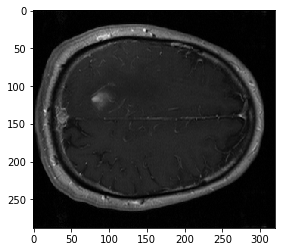

23


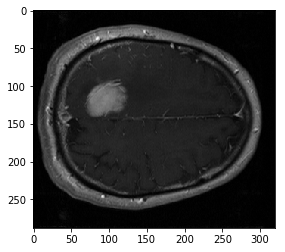

24


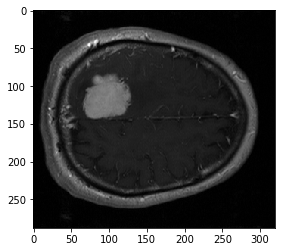

25


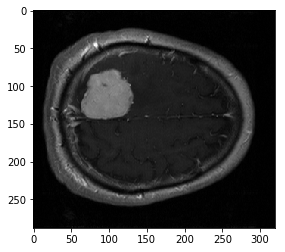

26


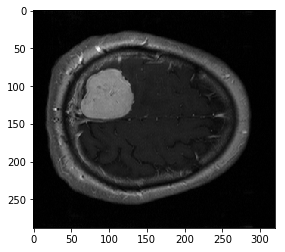

27


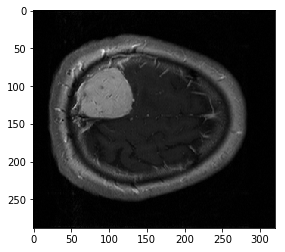

28


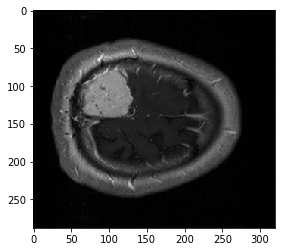

In [8]:
for i in range(22,29):
    print(i)
    slide = img_array[:,:,i]
    fig1 = pylab.figure()
    pylab.imshow(slide, cmap=pylab.cm.gist_gray)
    pylab.show()

In [9]:
slide = img_array[:,:,24]
print(slide.shape)
print(slide.dtype)
print(np.unique(slide))

(288, 320)
float64
[0.00000000e+00 1.01649498e+00 1.98678565e+00 ... 2.91498418e+03
 2.95398062e+03 2.97800687e+03]


### K-means application 
We need to segment the tumor, so we could to apply a clustering method (as K-means) and group pixels by gray scale

(288, 320)


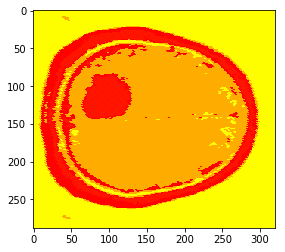

[[251 255 252]
 [232 243 232]
 [ 29  28  29]
 [102 100 102]]


In [18]:
img = slide
Z = img.reshape((-1,3))
print(slide.shape)
# convert to np.float32
Z = np.float32(Z)

# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 4
ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
image_kmeans = res.reshape((img.shape))

pylab.imshow(image_kmeans, cmap=pylab.cm.autumn_r)
pylab.show()

print(center)


We are only interested in the tumor cluster, therefore, we make zero all the other centroids

[[0 0 0]
 [1 1 1]
 [0 0 0]
 [0 0 0]]


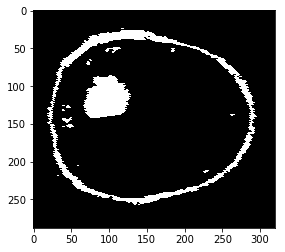

(288, 320)


In [19]:
for i, (centroid) in enumerate(center):
    for j, (value) in enumerate(centroid):
        if i == 1:
            center[i][j] = 1
        else:
            center[i][j] = 0
print(center)
# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
image_kmeans = res.reshape((img.shape))

pylab.imshow(image_kmeans, cmap=pylab.cm.gray)
pylab.show()

#print image size
print(image_kmeans.shape)

### Eroding and Dilating
Below I show the definition of these methods according to <a href="https://docs.opencv.org/2.4/doc/tutorials/imgproc/erosion_dilatation/erosion_dilatation.html"> the documentation of cv2 </a>

#### Dilating
> This operations consists of convoluting an image A with some kernel (B), which can have any shape or size, usually a square or circle.

> The kernel B has a defined anchor point, usually being the center of the kernel.

> As the kernel B is scanned over the image, we compute the maximal pixel value overlapped by B and replace the image pixel in the anchor point position with that maximal value. As you can deduce, this maximizing operation causes bright regions within an image to “grow” (therefore the name dilation).
<br><img src="https://docs.opencv.org/2.4/_images/Morphology_1_Tutorial_Theory_Dilatation_2.png">

#### Eroding
> This operation is the sister of dilation. What this does is to compute a local minimum over the area of the kernel.

> As the kernel B is scanned over the image, we compute the minimal pixel value overlapped by B and replace the image pixel under the anchor point with that minimal value.

> Analagously to the example for dilation, we can apply the erosion operator to the original image (shown above). You can see in the result below that the bright areas of the image (the background, apparently), get thinner, whereas the dark zones (the “writing”( gets bigger.
<br><img src="https://docs.opencv.org/2.4/_images/Morphology_1_Tutorial_Theory_Erosion_2.png">

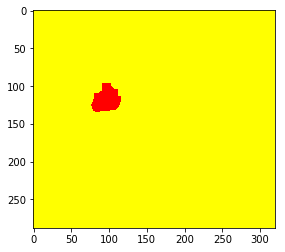

[0 1]
[0 1]


In [20]:
kernel = np.ones((15,15),np.uint8)
erosion = cv2.erode(image_kmeans,kernel,iterations = 1)
pylab.imshow(erosion, cmap=pylab.cm.autumn_r)
pylab.show()
print(np.unique(erosion))
print(np.unique(image_kmeans))


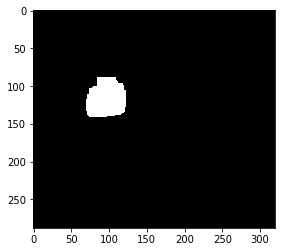

In [21]:
dilation = cv2.dilate(erosion,kernel,iterations = 1)
pylab.imshow(dilation, cmap=pylab.cm.gist_gray)
pylab.show()

In [22]:
np.unique(dilation)
print('Dilation shape: ',dilation.shape)
print('Dilation data type: ',dilation.dtype)
print('Values: ',np.unique(dilation))

Dilation shape:  (288, 320)
Dilation data type:  uint8
Values:  [0 1]


### Masking 
Notice that we already have a mask (image which has the same dimensions as the real image but with values 0 and 1). Now it's time to multiplicate both images and output only the region of interest

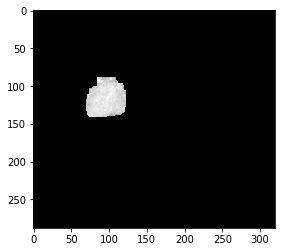

In [23]:
new_slide = img * dilation
pylab.imshow(new_slide, cmap=pylab.cm.gist_gray)
pylab.show()

### Painting the tumor "in depth"
When we obtained the correct filtering we'll be able to extract the tumor in all slides (depth dimension). For this, we proposed to use the min and max value of the gray magnitude in the tumor and we define a range to paint. Then the idea is: 
<center>
*"I'm going to go pixel by pixel (in the original image) and if the pixel magnitude is in the range of the tumor magnitudes, I paint it"*.
<center>

In [24]:
min_value = np.min(np.unique(new_slide)[1:])
max_value = np.max(np.unique(new_slide)[1:])

print('max tumor :',max_value)
print('min tumor ;',min_value)
print(np.unique(new_slide).shape)
print(np.unique(img).shape)

maxi = np.max(img_array)
lower = np.min(img_array)
print('max all: ',maxi)
print('min all: ',lower)

max tumor : 1598.9928109161556
min tumor ; 911.0105254091322
(445,)
(1806,)
max all:  3027.999938260764
min all:  0.0


We only consider the interest range (remind that the range was empirically defined as [22, 29])

In [25]:
size = img_array.shape[2]
new_image = np.zeros((img_array.shape), dtype=np.int16)
print(new_image.shape)
for i in range(22, 29):
    slide = img_array[:,:,i]
    print('reading slide: ',i)
    x_dim = slide.shape[0]
    y_dim = slide.shape[1]
    for x in range(0,x_dim):
        for y in range(0,y_dim):
            partial = float(slide[x,y])
            if (partial>min_value-1) and (partial < max_value+1):
                new_image[x,y,i] = img_array[x,y,i]
            else:
                #print(min_value,'-',partial,'-',max_value)
                new_image[x,y,i] = 0
            
    

(288, 320, 33)
reading slide:  22
reading slide:  23
reading slide:  24
reading slide:  25
reading slide:  26
reading slide:  27
reading slide:  28


### Display the new set of slides

0


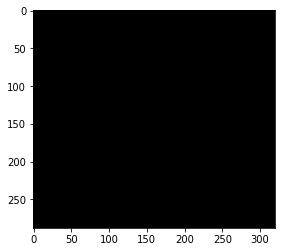

1


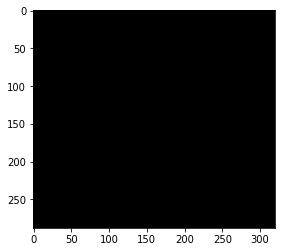

2


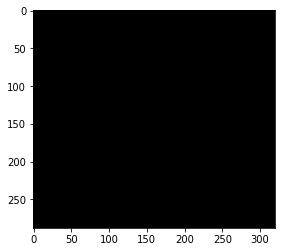

3


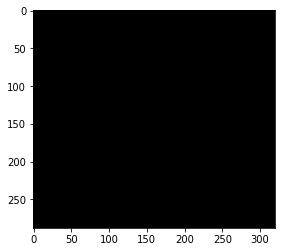

4


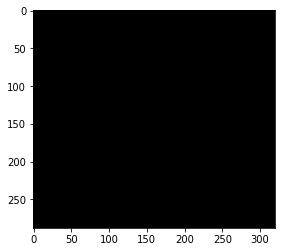

5


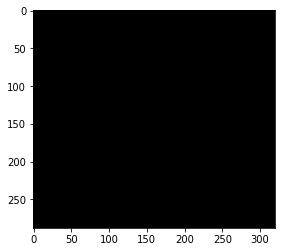

6


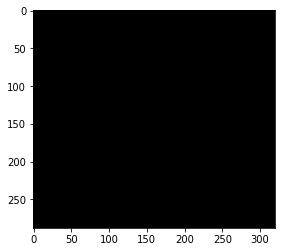

7


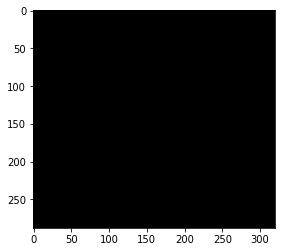

8


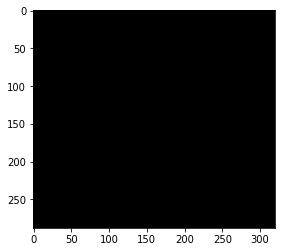

9


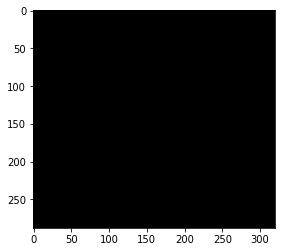

10


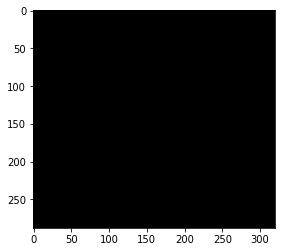

11


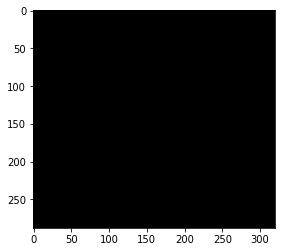

12


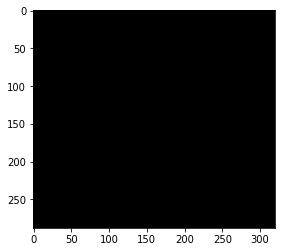

13


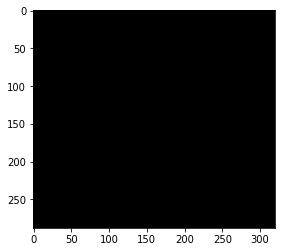

14


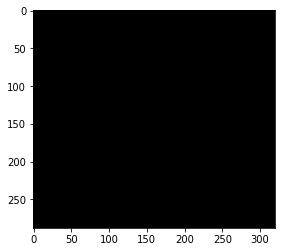

15


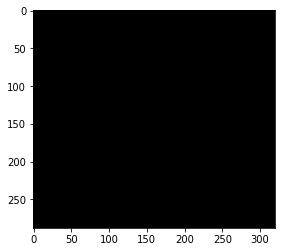

16


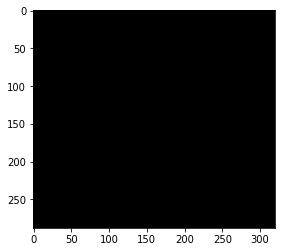

17


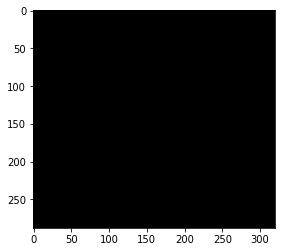

18


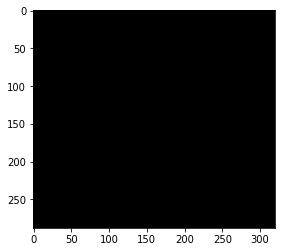

19


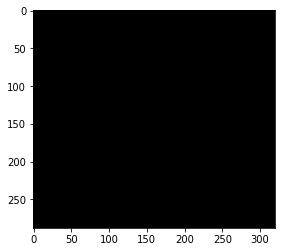

20


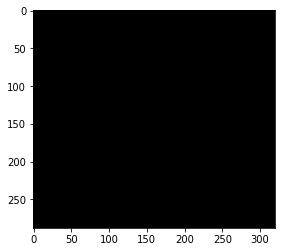

21


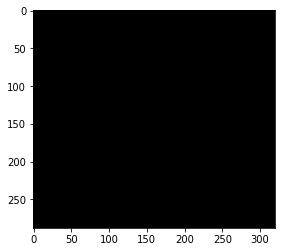

22


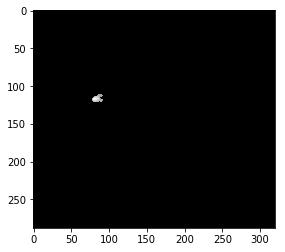

23


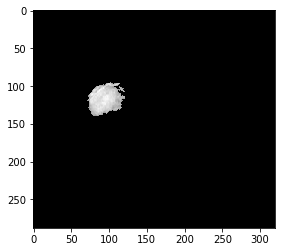

24


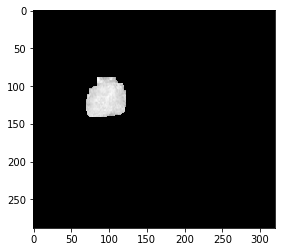

25


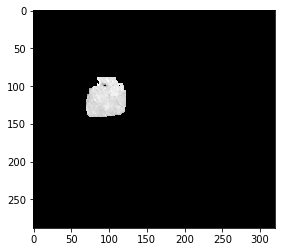

26


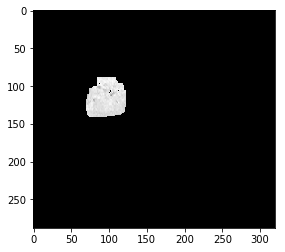

27


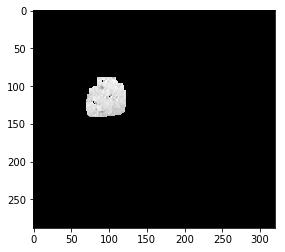

28


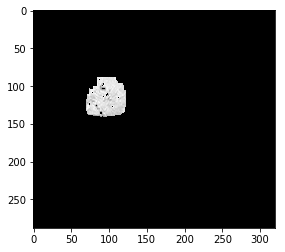

29


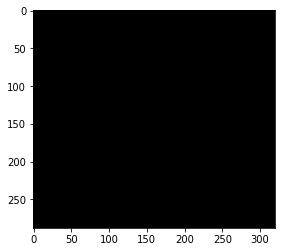

30


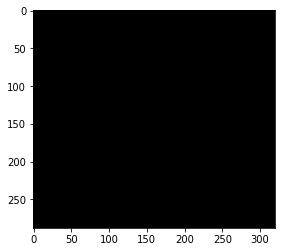

31


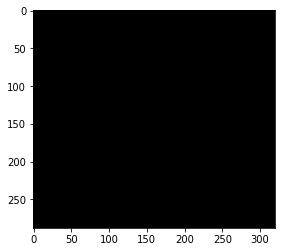

32


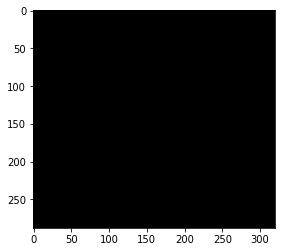

In [26]:
size_new = new_image.shape[2]
for i in range(0, size_new):
    print(i)
    slide_ = new_image[:,:,i] * dilation
    fig1 = pylab.figure()
    pylab.imshow(slide_, cmap=pylab.cm.gist_gray)
    pylab.show()

### Saving image

In [27]:
img = nib.load("cases/case_001_2.nii")
header_x = img.header.copy()
new_image_nifti = nib.Nifti1Image(new_image, None, header=header_x)

In [28]:
nib.save(new_image_nifti, './new_image.nii')

In [29]:
imagen = nib.load('./new_image.nii')
header2 = imagen.header

### Calculating the approximate volume and diameter
First, notice that the header bring us information about the voxel size. So, To calculate the volume we have to count all of pixels (voxels) in each slide which are painted and then we multiply the particular voxel volume for these quantity.<br><br>
Diameter is calculate using the *model slide* and measuring the maximum distance between pixels

In [30]:
dim = header2.get_zooms()
v_x = dim[0]
v_y = dim[1]
v_z = dim[2]

In [31]:
painted_pixel = 0
array_image = imagen.get_data()
array_original = img.get_data()
for slide in array_image[:,:,22:29]:
    for rows in slide:
        for pixel in rows:
            if pixel != 0:
                painted_pixel+=1

print ('painted pixels: ',painted_pixel)


painted pixels:  66880


In [32]:
volume_voxel = v_x*v_y*v_z
volume = volume_voxel * painted_pixel

To find the diameter We went through each row and counted the amount of nonzero values. Then we did the same for the columns. Finally, the maximum amount of non-zero values between rows and columns defines the diameter.

In [33]:
max_value_row = 0
for rows in dilation:
    partial_min_row = collections.Counter(rows)[1]
    if partial_min_row > max_value_row:
        max_value_row = partial_min_row

max_value_col = 0
for cols in dilation.T:
    partial_min_col = collections.Counter(cols)[1]
    if partial_min_col > max_value_col:
        max_value_col = partial_min_col

In [34]:
if max_value_row > max_value_col:
    diameter = max_value_row
else:
    diameter = max_value_col


In [35]:
new_array = imagen.get_data()
mean = np.mean(new_array)
desv = np.std(new_array)

In [37]:
print('Volume: ',volume, 'mm^3')
print('Diameter', diameter, 'mm')
print('Mean of Voxel magnitude: ', mean)
print('Standar Desviation of Voxel magnitude: ', desv)

Volume:  114949.88040924072 mm^3
Diameter 53 mm
Mean of Voxel magnitude:  26.164723734743266
Standar Desviation of Voxel magnitude:  176.44342290511935


### Alternative solution for the diameter (not considered)

In [ ]:
       
for j, (rows) in enumerate(dilation):
    partial_min_row = collections.Counter(rows)[1]
    if partial_min_row != 0:
        for i, (pix)in enumerate(rows):
            if pix == 1:
                point1 = (j, i)
                break
for j, (rows) in enumerate(dilation[::-1]):
    partial_min_row = collections.Counter(rows)[1]
    if partial_min_row != 0:
        for i, (pix)in enumerate(rows):
            if pix == 1:
                point2 = (j, i)
                break
for j, (rows) in enumerate(dilation.T):
    partial_min_row = collections.Counter(rows)[1]
    if partial_min_row != 0:
        for i, (pix)in enumerate(rows):
            if pix == 1:
                point3 = (j, i)
                break
for j, (rows) in enumerate(dilation.T[::-1]):
    partial_min_row = collections.Counter(rows)[1]
    if partial_min_row != 0:
        for i, (pix)in enumerate(rows):
            if pix == 1:
                point4 = (j, i)
                break

diameter_1 = ((point2[0]-point1[0])**2 + (point2[0]-point1[0])**2)**(1/2)
diameter_2 = ((point4[0]-point3[0])**2 + (point4[0]-point3[0])**2)**(1/2)

if diameter_1 > diameter_2:
    diameter = diameter_1
else:
    diameter = diameter_2
